Histogramm

In [100]:
from sklearn import datasets
import math
import numpy as np


def get_train_test_data(n=100, seed=11121):
    # Generate all data
    data_all = datasets.make_moons(n, random_state=seed)[0]

    # Split into train/test data
    train_n = math.floor(0.8 * n)
    train_data = data_all[:train_n]
    test_data = data_all[train_n:]

    return train_data, test_data

train_data, test_data = get_train_test_data()

test_data_n = []
train_data_n = []
n_samples = [100,1000,10000]
for n in n_samples:
    train, test = get_train_test_data(n)
    test_data_n.append(test)
    train_data_n.append(train)
    


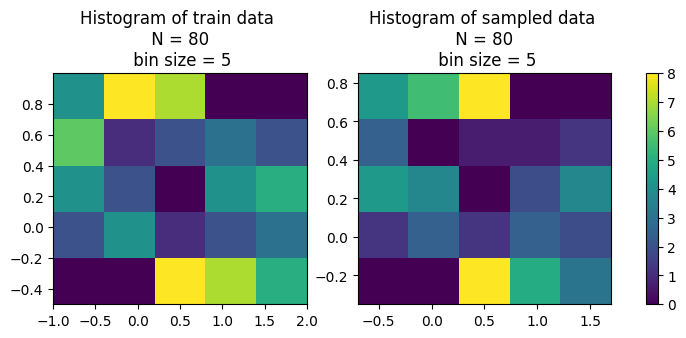

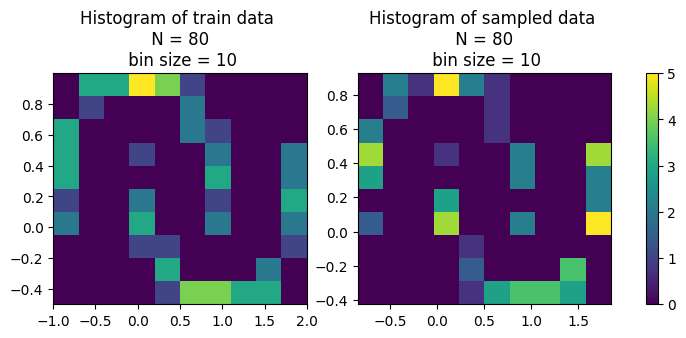

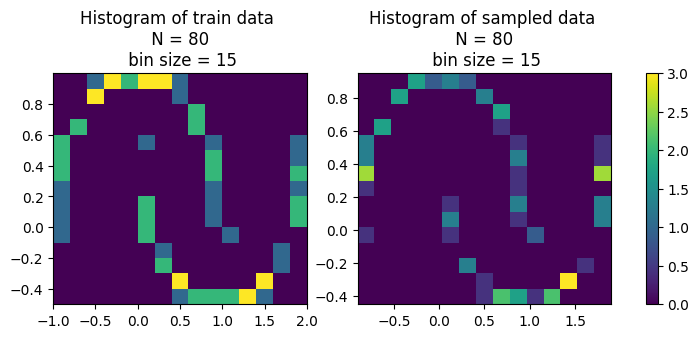

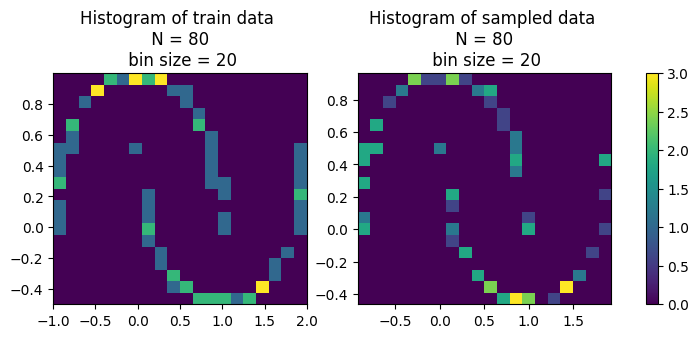

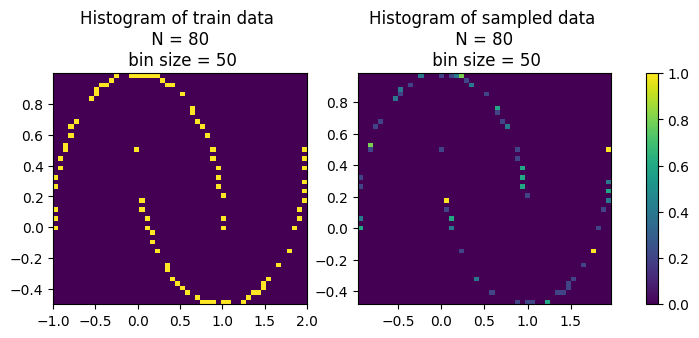

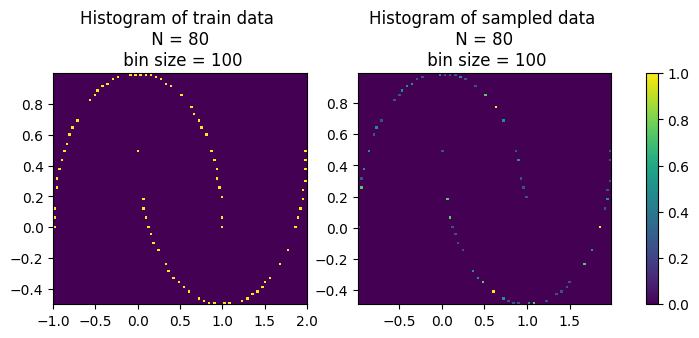

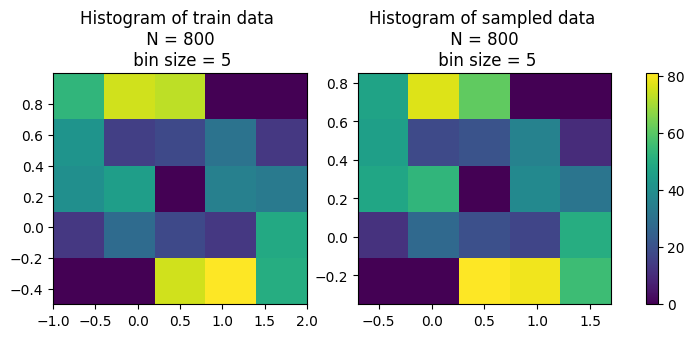

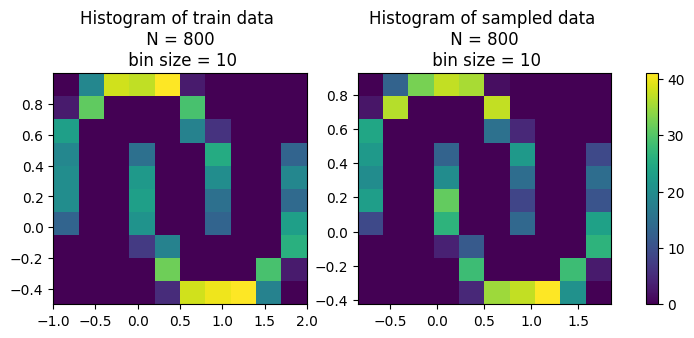

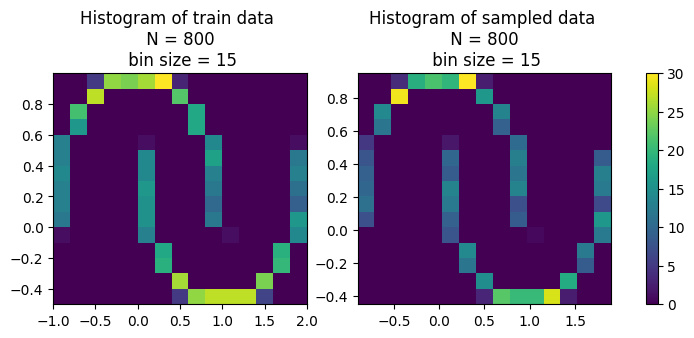

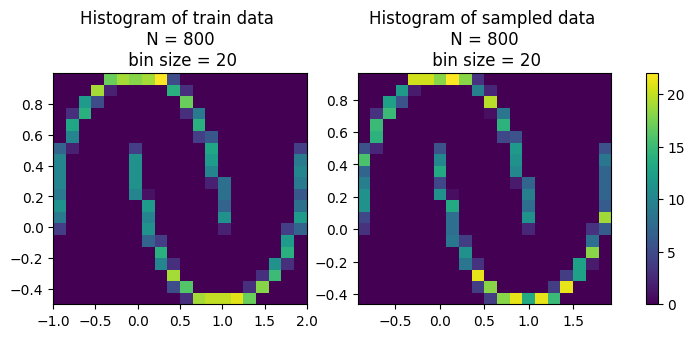

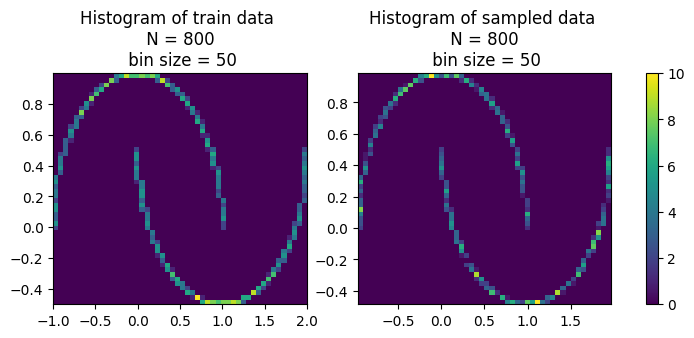

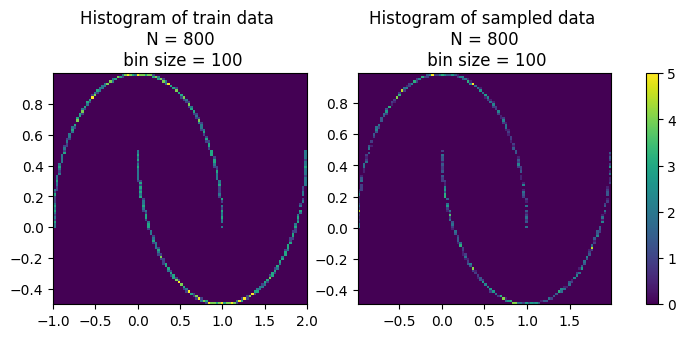

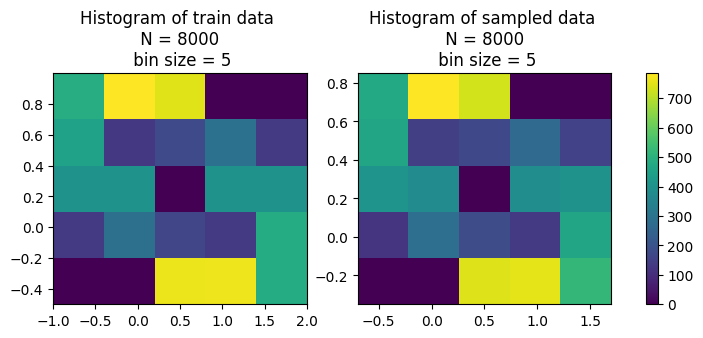

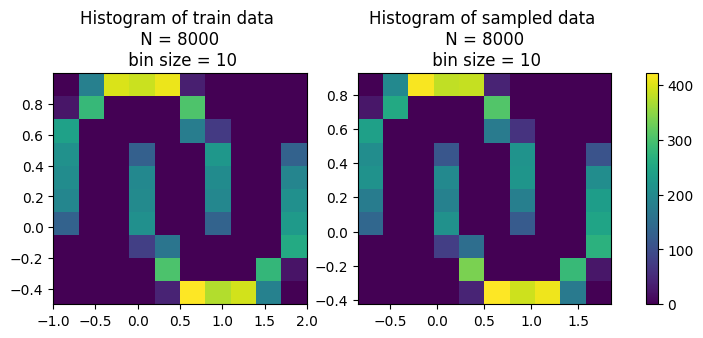

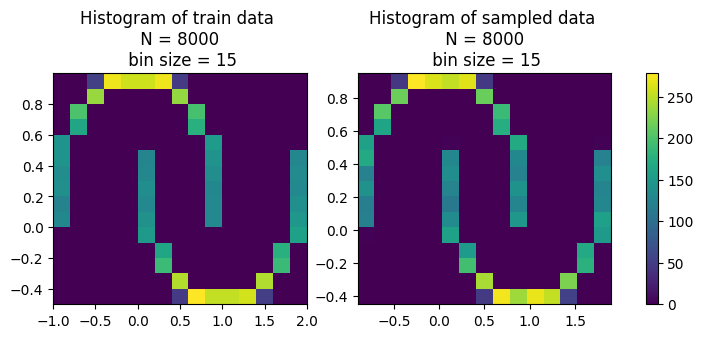

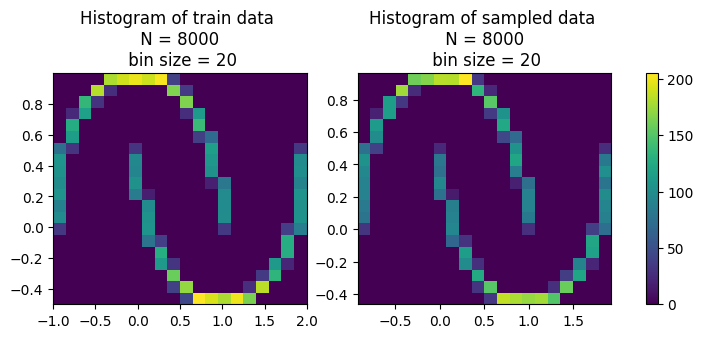

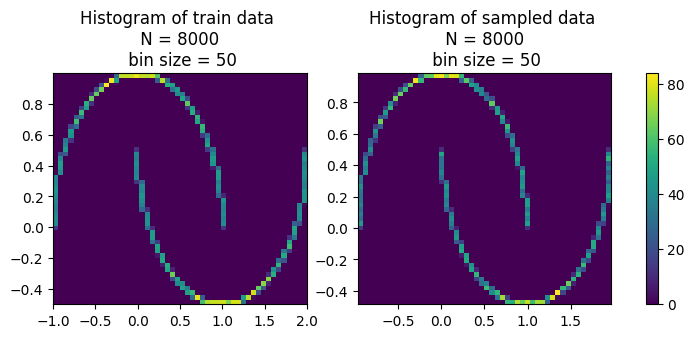

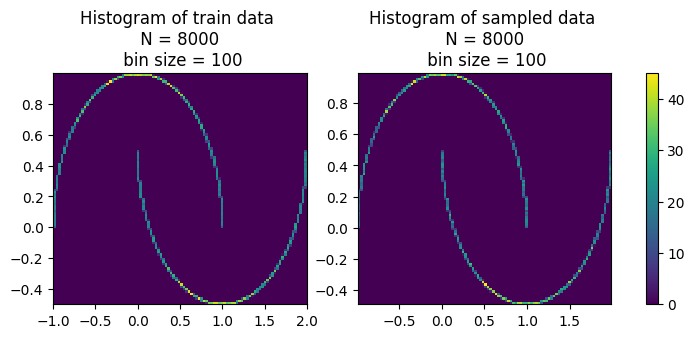

In [108]:
# Calculating necessary quantities
import matplotlib.pyplot as plt

bin_sizes = [5,10,15,20,50,100]
for i,train_data_i in enumerate(train_data_n):
    for j,bins in enumerate(bin_sizes):
        # Calculate for X
        smallest_X = np.min(train_data_i[:, 0])
        largest_X = np.max(train_data_i[:, 0])
        sorted_X = train_data_i[np.argsort(train_data_i[:, 0])]
        Quantiles_X = np.quantile(sorted_X[:, 0], [0.25, 0.5, 0.75])
        IQR = Quantiles_X[2] - Quantiles_X[0]
        Stepsize_X = 2 * IQR / pow(80,1/3)
        CountBins_X = (largest_X - smallest_X) / Stepsize_X
        CountBins_X = math.ceil(CountBins_X)
    

        #Calculate for Y
        smallest_Y = np.min(train_data_i[:, 1])
        largest_Y = np.max(train_data_i[:, 1])
        sorted_y =  train_data_i[np.argsort(train_data_i[:, 1])]
        Quantiles_Y = np.quantile(sorted_y[:, 1], [0.25, 0.5, 0.75])
        IQR = Quantiles_Y[2] - Quantiles_Y[0]
        Stepsize_Y = 2 * IQR / pow(80,1/3)
        CountBins_Y = (largest_Y - smallest_Y) / Stepsize_Y
        CountBins_Y = math.ceil(CountBins_Y)
    

        #Create Histograms
        hist, x_bins, y_bins = np.histogram2d(train_data_i[:, 0], train_data_i[:, 1], bins=[bins, bins])

        # Get bin centers for sampling
        x_bin_midpoints = (x_bins[:-1] + x_bins[1:])/2
        y_bin_midpoints = (y_bins[:-1] + y_bins[1:])/2

        # plot histogram with train_data
        fig, axs = plt.subplots(1,2,figsize= (9,3))
        h = axs[0].hist2d(train_data_i[:, 0],train_data_i[:, 1],bins=(bins,bins))
        N = str(len(train_data_i))
        axs[0].set_title('Histogram of train data \n N = %i \n bin size = %i' %(len(train_data_i),bins))
        fig.colorbar(h[3], ax=axs)

        #Calcuate cdf
        cdf = np.cumsum(hist.flatten())
        cdf = cdf / cdf[-1] #normalize cdf

        #Create sampled data
        n_samples[i]
        values = np.random.rand(n_samples[i])
        value_bins = np.searchsorted(cdf, values)
        x_idx,y_idx=np.unravel_index(value_bins,(len(x_bin_midpoints),len(y_bin_midpoints)))
        train_from_cdf = np.column_stack((x_bin_midpoints[x_idx],y_bin_midpoints[y_idx]))
        new_x,new_y = train_from_cdf.T

        #plot random sampled data
        axs[1].hist2d(new_x,new_y,bins=(bins,bins))
        axs[1].set_title('Histogram of sampled data \n N = %i \n bin size = %i' %(len(train_data_i),bins))
        
        

    


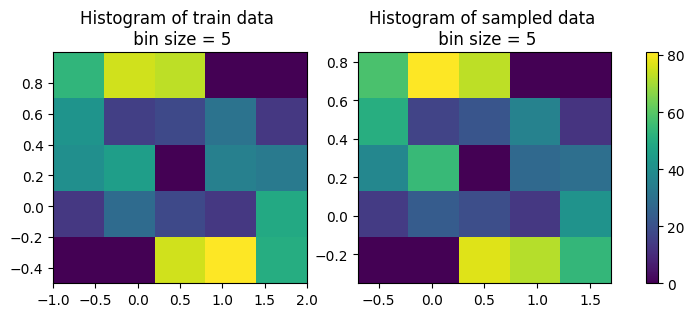

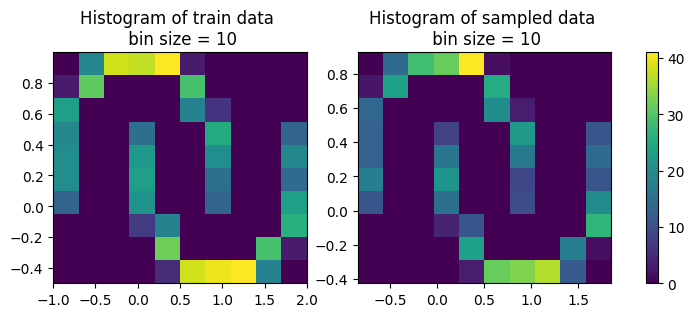

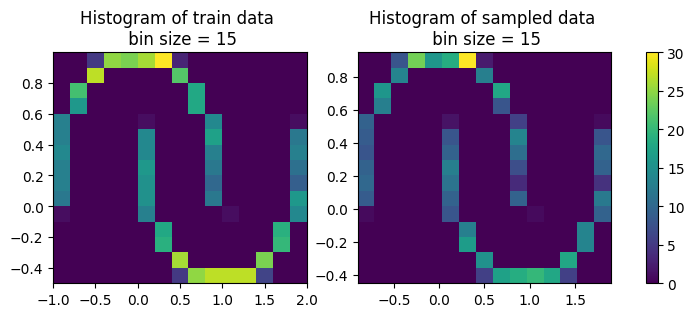

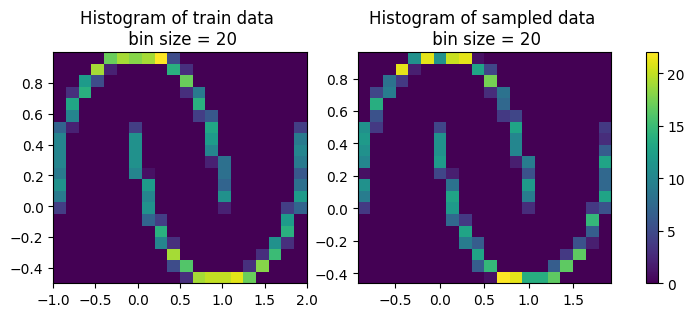

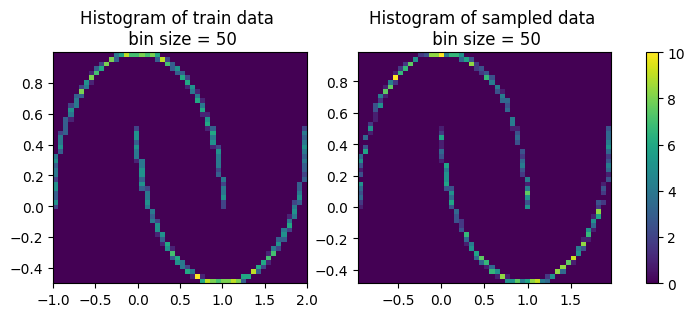

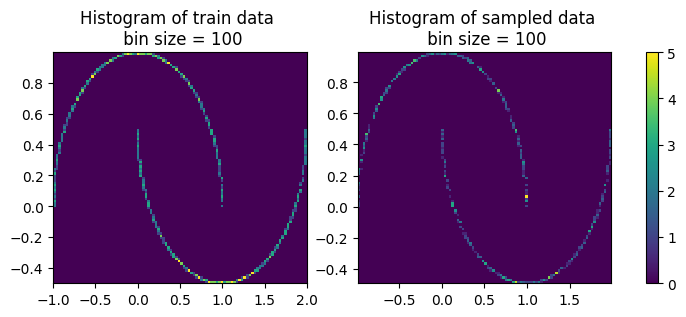

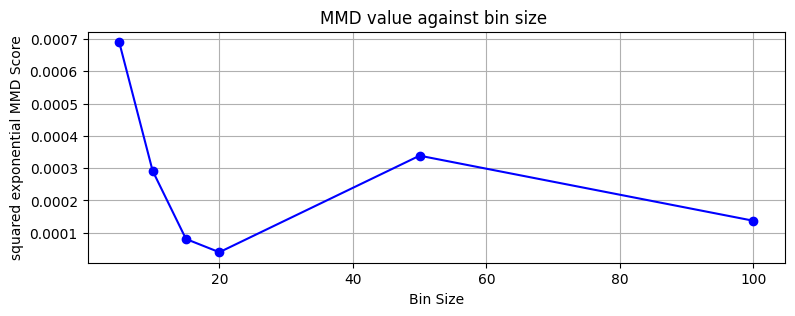

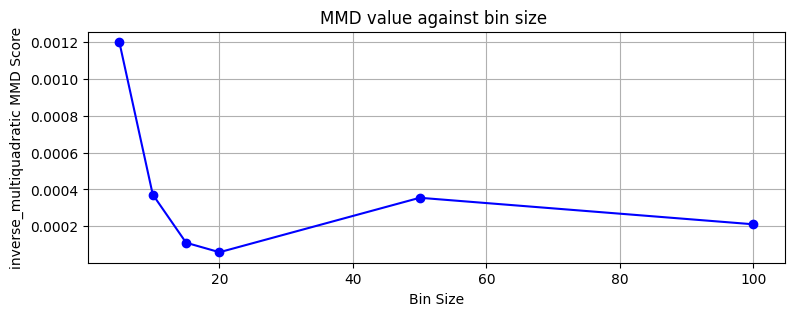

In [112]:
#MMD Evaluation
from MMD.MMD import calculate_mmd

train_data = train_data_n[1] 
n = len(train_data) # size n = 1000

#Creating different bin sizes
bin_sizes = [5,10,15,20,50,100]
mmd_scores_exponential = []
mmd_scores_multiquadratic = []

#MMD for each bin size
for bins in bin_sizes:
    # Create a 2D histogram of the test data
    hist, x_edges, y_edges = np.histogram2d(train_data[:, 0], train_data[:, 1], bins=bins, density=True)
    
    #plot histogram
    fig, axs = plt.subplots(1,2,figsize= (9,3))
    h = axs[0].hist2d(train_data[:, 0],train_data[:, 1],bins=(bins,bins))
    N = str(len(train_data))
    axs[0].set_title('Histogram of train data \n bin size = %i' %bins)
    fig.colorbar(h[3], ax=axs)

    # Get bin centers for sampling
    x_bin_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_bin_centers = (y_edges[:-1] + y_edges[1:]) / 2

    cdf = np.cumsum(hist.flatten())
    cdf = cdf / cdf[-1] #normalize cdf
    
    # Generate samples from the histogram
    values = np.random.rand(n)
    value_bins = np.searchsorted(cdf, values)
    x_idx,y_idx=np.unravel_index(value_bins,(len(x_bin_centers),len(y_bin_centers)))
    train_from_cdf = np.column_stack((x_bin_centers[x_idx],y_bin_centers[y_idx]))
    new_x,new_y = train_from_cdf.T
    
    #plot sampled histogram
    axs[1].hist2d(new_x,new_y,bins=(bins,bins))
    axs[1].set_title('Histogram of sampled data \n bin size = %i' %bins)
    
    # Calculate MMD between the train_data and the generated samples
    mmd_score = calculate_mmd(train_data, train_from_cdf, bandwidths=[1.0, 2.0])
    for kernel, mmd_value in mmd_score.items():
        if kernel == 'squared_exponential':
            mmd_scores_exponential.append(mmd_value)
            
        else:
            mmd_scores_multiquadratic.append(mmd_value)
  
plt.figure(figsize=(9, 3))
plt.plot(bin_sizes, mmd_scores_exponential, marker="o", color="b")
plt.title("MMD value against bin size ")
plt.xlabel("Bin Size")
plt.ylabel("squared exponential MMD Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(9, 3))
plt.plot(bin_sizes, mmd_scores_multiquadratic, marker="o", color="b")
plt.title("MMD value against bin size ")
plt.xlabel("Bin Size")
plt.ylabel("inverse_multiquadratic MMD Score")
plt.grid(True)


## Observings of the results:
    -  different kernels of MMD select similar good and worse models
    -  small bin sizes (<20) do not approximate original distribution well
    -  smallest MMD around bin_size 20 meaning that a bin size of 20 may approximate the original data the best.
    - increasing bin size (>20) do not really improve MMD so there is no significant improvement in the distribution match
    - you can see from results that sampling from histogram is sensitive to bin sizes and using a appropriate bin size is important in order to not miss distributional details or lead to overfitting
    - almost in every histogram (exception bin size 5) you can see the shape of the two moons. 
    - from the histograms above you can conclude that different bin sizes work best for a different amount of data
    
## Strenghts
- easy to understand, intuitive approximation
-> easy to interpret
- works good for 1D/2D
- can adjust model by choosing different bin sizes
-> finner binning: more detail, coarser binning:smoother approximations for bigger datasets
## Weaknesses
- bin size impact accuracy of model
-> choosing right bin size is not easy (requires further testing)
- sensitive when it comes to higher dimensions
 